In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import astropy.units as u
import numpy as np
from exo_finder.data_pipeline.generation.dataset_generation import TransitProfile
from exo_finder.data_pipeline.generation.time_generation import generate_time_days_of_length
from exo_finder.data_pipeline.generation.transit_generation import PlanetType, PeriodFrequency,generate_transits_from_params, generate_transit_parameters
from exo_finder.default_datasets import gaia_dataset

In [2]:
fields = ["gaia_id", "radius", "mass_flame", "teff_mean"]
gaia_df = gaia_dataset.load_gaia_parameters_dataset().to_pandas()[fields].dropna()
print("Dataset size:", len(gaia_df))

Dataset size: 236728


In [3]:
%load_ext autoreload
%autoreload 2

Star 5500121959478471936: Radius 1.6384141445159912, Mass 1.045820713043213, Teff 5791.3394775390625


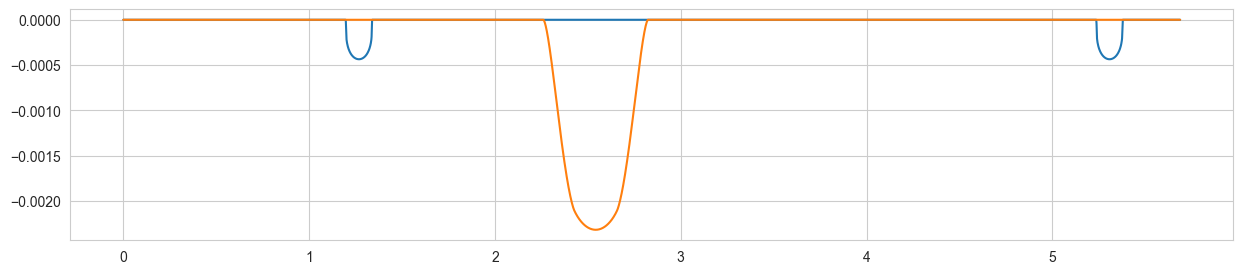

In [230]:
sample = gaia_df.sample(1)
radius, mass, teff = sample["radius"].item(), sample["mass_flame"].item(), sample["teff_mean"].item()
print(f"Star {sample['gaia_id'].item()}: Radius {radius}, Mass {mass}, Teff {teff}")
mass = mass * u.solMass
radius = radius * u.solRad
teff = teff * u.K

params_e = generate_transit_parameters(
    planet_type=PlanetType.MINI_NEPTUNE,
    orbital_period_interval=PeriodFrequency.THREE_TO_TEN_DAYS,
    star_radius=radius,
    star_mass= mass,
    transit_midpoint_range=(1, 2),
)

params_j = generate_transit_parameters(
    planet_type=PlanetType.JUPITER,
    orbital_period_interval=(1000, 1000),
    star_radius=radius,
    star_mass= mass,
    transit_midpoint_range=(0, 5),
)

x = generate_time_days_of_length(2**12)
transits_e = generate_transits_from_params(params_e, x)
transits_j = generate_transits_from_params(params_j, x)

plt.figure(figsize=(15, 3))
plt.plot(x, transits_e)
plt.plot(x, transits_j)
plt.show()

### Generate dataset and study the distribution of parameters

In [233]:
# Hot Jupyters: short period, at least 2 transits
hot_jupyters = TransitProfile(
    planet_type=PlanetType.JUPITER,
    transit_period_range=(1, 10),
    transit_midpoint_range=(0, 5),
    weight=1,
)
hot_jupyters = TransitProfile(
    planet_type=PlanetType.JUPITER,
    transit_period_range=(1, 10),
    transit_midpoint_range=(0, 5),
    weight=1,
)
n = 1000

rndgen = np.random.default_rng(8)
sample_stars = gaia_df.sample(n, replace=True, random_state=8)

all_params = []
for i, row in sample_stars.iterrows():
    for planet_type in PlanetType:
        all_params.append(generate_transit_parameters(
            planet_type=planet_type,
            orbital_period_interval=(1, 10),
            transit_midpoint_range=(0, 5),
            star_radius=row["radius"] * u.solRad,
            star_mass=row["mass_flame"] * u.solMass,
            rnd_generator=rndgen
        ))

all_transits = [generate_transits_from_params(p, x) for p in all_params]
all_transits = np.vstack(all_transits)

params_df = pd.DataFrame([p.to_dict() for p in all_params])
params_df

,period_d,transit_midpoint_d,planet_radius_solrad,star_radius_solrad,semi_major_axis_solrad,planet_mass_solmass,inclination_deg,eccentricity,argument_of_periastron_deg,limb_darkening_c1,limb_darkening_c2
0,2.083103,4.349483,0.007916,1.070165,8.672309,0.000002,86.908835,0.008434,140.790530,0.587438,0.141221
1,3.012766,1.206761,0.015444,1.070165,11.091063,0.000016,88.788307,0.169375,92.572289,0.587438,0.141221
2,2.648404,2.954514,0.027363,1.070165,10.177764,0.000016,86.586926,0.297074,217.538027,0.587438,0.141221
3,2.351728,1.423103,0.062550,1.070165,9.403432,0.000239,88.802864,0.217906,6.041539,0.587438,0.141221
4,4.137404,3.036653,0.085885,1.070165,13.705682,0.000614,89.401964,0.079064,80.301595,0.587438,0.141221
...,...,...,...,...,...,...,...,...,...,...,...
5995,5.959676,1.947035,0.015615,0.735103,16.245389,0.000013,88.231819,0.132413,241.267505,0.521562,0.201457
5996,6.342250,3.108165,0.035590,0.735103,16.933505,0.000029,88.759003,0.224893,240.956216,0.521562,0.201457
5997,7.275524,0.317856,0.060595,0.735103,18.558084,0.000247,89.907053,0.380238,178.546828,0.521562,0.201457
5998,2.384891,0.454095,0.105985,0.735103,8.825477,0.001006,88.109977,0.171206,147.279363,0.521562,0.201457


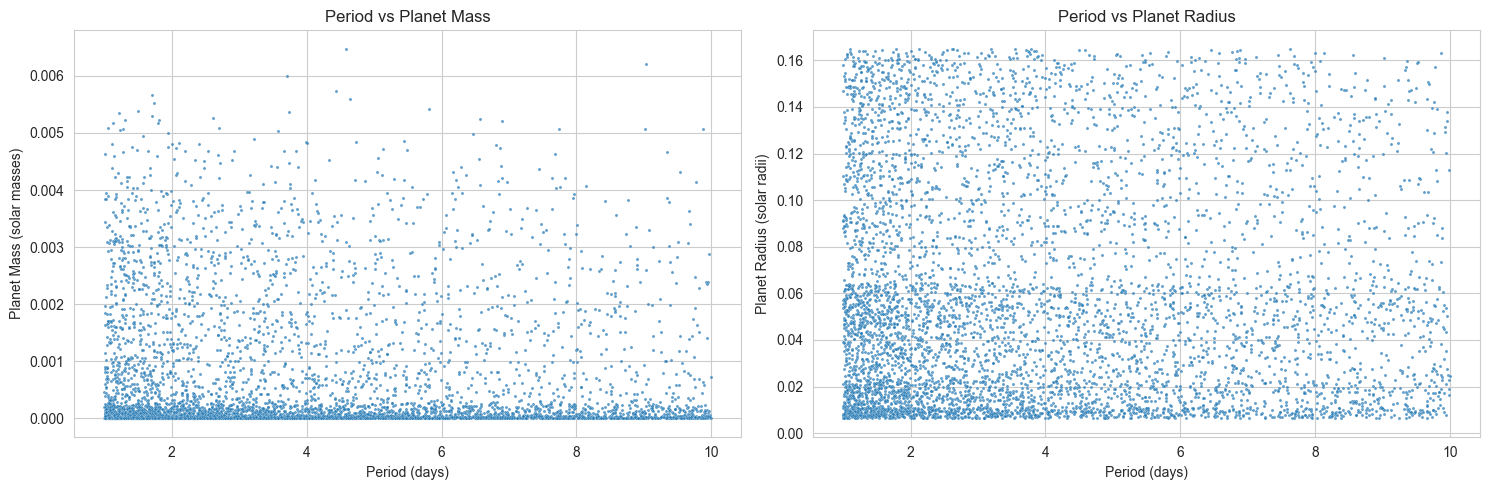

In [249]:
import seaborn as sns
period_mass = params_df[["period_d", "planet_mass_solmass"]].to_numpy()
period_radius = params_df[["period_d", "planet_radius_solrad"]].to_numpy()

# Create a figure with two subplots arranged vertically
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot period vs mass in the first subplot
sns.scatterplot(x="period_d", y="planet_mass_solmass", data=params_df, s=5, alpha=0.7, ax=ax1)
ax1.set_title('Period vs Planet Mass')
ax1.set_xlabel('Period (days)')
ax1.set_ylabel('Planet Mass (solar masses)')

# Plot period vs radius in the second subplot
sns.scatterplot(x="period_d", y="planet_radius_solrad", data=params_df, s=5, alpha=0.7, ax=ax2)
ax2.set_title('Period vs Planet Radius')
ax2.set_xlabel('Period (days)')
ax2.set_ylabel('Planet Radius (solar radii)')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()